### Google Drive setup

In [0]:
g_drive = True

In [32]:
if g_drive:
    from google.colab import drive
    drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
if g_drive:
    main_path = '/content/gdrive/My Drive/Projects/ai_contest_2019/final/'
else:
    main_path = ''

In [0]:
import pandas as pd
import json
import numpy as np
import seaborn as sns

### Data upload

In [0]:
# df_train = pd.read_csv(f'{main_path}data/academy2019_final_train.csv', index_col='id')
df_train = pd.read_csv(
    'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_train.csv',
    index_col='id')

# df_test = pd.read_csv(f'{main_path}data/academy2019_final_test.csv', index_col='id')
df_test = pd.read_csv(
    'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_test.csv',
    index_col='id')

In [0]:
players_ids = list(df_train.index)
skilled_ids = list(df_train[df_train['skilled'] == 1].index)
unskilled_ids = list(df_train[df_train['skilled'] == 0].index)

### json line reading

In [37]:
records = []
import json
from urllib.request import urlopen

# with urlopen(f'{main_path}data/academy2019_final_train.jsonlines', index_col='id') as fin:
with urlopen('https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_train.jsonlines') as fin:
    i = 0
    for line in fin:
        print(i)
        new_record = json.loads(line)
        break

0


In [38]:
print(new_record.keys())

dict_keys(['player_team', 'winner_team', 'duration', 'pre_game_duration', 'first_blood_time', 'first_blood_claimed', 'team_fight_participation', 'stuns', 'observer_wards_placed', 'sentry_wards_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'tower_kills', 'roshan_kills', 'nearby_creep_death_count', 'damage_targets', 'radiant_tower_status', 'dire_tower_status', 'radiant_barracks_status', 'dire_barracks_status', 'hero_id', 'hero_pick_order', 'leaver_status', 'party_players', 'kills', 'deaths', 'assists', 'level', 'gold', 'net_worth', 'gold_spent', 'last_hits', 'denies', 'gold_per_min', 'xp_per_min', 'hero_damage', 'tower_damage', 'hero_healing', 'scaled_hero_damage', 'scaled_tower_damage', 'scaled_hero_healing', 'avg_kills_x16', 'avg_deaths_x16', 'avg_assists_x16', 'avg_gpm_x16', 'avg_xpm_x16', 'best_kills_x16', 'best_assists_x16', 'best_gpm_x16', 'best_xpm_x16', 'win_streak', 'best_win_streak', 'fight_score', 'farm_score', 'support_score', 'push_score', 'final_items', 'abili

#### Значения полей

- `damage_targets`: количество нанесенного игроком урона по всем видам юнитов
- `radiant_heroes`, `dire_heroes`: список идентификаторов героев у всех игроков в команде (расшифровку см. в таблице `heroes.csv`)
- `final_items`: предметы инвентаря, собранные игроком к концу игры (0 означает отсутствие предмета в соответствующем слоте, расшифровку предметов см. в таблице `items.csv`)
- `level_up_times`: время, в которое герой игрока повышал уровень
- `ability_upgrades`: последовательность улучшений умений, которые делал игрок (возможность улучшить умение возникает при повышении уровня героя, расшифровка умений см. в таблице `abilities.csv`)
- `item_purchase_log`
- `series`: временные ряды изменения игровых показателей во времени
  - `time`: отсчеты времени
  - `radiant_gold`, `dire_gold`: суммарное число золота, заработанного командами
  - `player_gold`: число золота, заработанное игроком
- `kills_log`, `deaths_log`: списки убийств и смертей героя во время игры, указано время и координаты события на карте
- `wards`: список установленных игроком "вардов" — специальных игровых предметов, которые дают обзор карты в некотором радиусе
- `gold_by_reason`: информация о том, по какой причине сколько золота было получено
- `actions`: действия мышкой за первые 10 минут игры, в колоночном формате со следующими полями:
  - `time`: время действия
  - `order_type`: тип действия
  - `camera_(x,y)`: положение камеры в момент действия
  - `cursor_(x,y)`: положение курсора на экране в момент действия
  - `pos_(x,y)`: координаты действия на игровой карте; в случае если действие не относится к карте — (0, 0)
- `pings`: "пинги" — сообщения, которые делал игрок союзникам о некоторой важной точке на карте, в колоночном формате

### Time series example

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['record']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


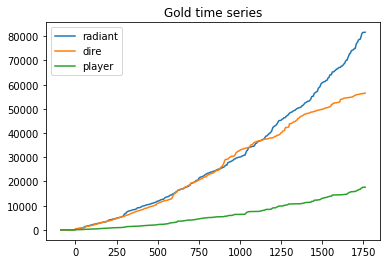

In [39]:
%pylab inline
series = new_record['series']
plot(series['time'], series['radiant_gold'])
plot(series['time'], series['dire_gold'])
plot(series['time'], series['player_gold'])
title('Gold time series')
_ = legend(['radiant', 'dire', 'player'])

In [40]:
series_df = pd.DataFrame(series)
# series_df = series_df.set_index(['time'])
series_df.head()

,time,radiant_gold,dire_gold,player_gold
0,-89.12,0,0,0
1,-84.12,0,0,0
2,-79.12,0,0,0
3,-74.12,0,0,0
4,-69.12,0,0,0


### Heroes export

In [43]:
%%time
# Heroes ids bag-of-word coding
heroes_dfs=[]
for name in ('train', 'test'):
    heroes_df = pd.DataFrame(columns = ['id', 'hero_id'])
    heroes_ids_n = set(pd.read_csv(f'{main_path}data/dota2_heroes.csv')['hero_id'])
    heroes_ids_n = sorted(list(heroes_ids_n))
    heroes_ids = [f'h{i}' for i in heroes_ids_n]
    rows_h_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
         for line in fin:
            record = json.loads(line)
            rows_h_list.append([record['id']] + [[record['radiant_heroes']+record['dire_heroes']][0].count(hero_id) for hero_id in heroes_ids_n])
    
    heroes_df = pd.DataFrame(rows_h_list)
    heroes_df = heroes_df.set_index(0)
    heroes_df.columns = heroes_ids
    heroes_df.to_csv(f'{main_path}data/heroes_{name}.csv')
    print(name)
    heroes_dfs.append(heroes_df)

train
test
CPU times: user 2min 46s, sys: 6.34 s, total: 2min 52s
Wall time: 3min 45s


### Items export

In [44]:
%%time
# items bag-of-words coding
items_dfs=[]
for name in ('train', 'test'):
    items_df = pd.DataFrame(columns = ['id', 'final_items'])
    items_ids_n = set(pd.read_csv(f'{main_path}data/dota2_items.csv')['item_id'])
    items_ids_n = sorted(list(items_ids_n))
    items_ids = [f'i{i}' for i in items_ids_n]
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            rows_i_list.append([record['id']] + [record['final_items'].count(item_id) for item_id in items_ids_n])
    
    items_df = pd.DataFrame(rows_i_list)
    items_df = items_df.set_index(0)
    items_df.columns=items_ids
    items_df.to_csv(f'{main_path}data/final_items_{name}.csv')
    items_dfs.append(items_df)

CPU times: user 3min 1s, sys: 6.16 s, total: 3min 7s
Wall time: 3min 48s


### Gold features

In [46]:
%%time
# Gold sums
gold_dfs=[]
for name in ('train', 'test'):
    gold_ids = ['radiant_gold', 'dire_gold']
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            gold_r = record['series']['radiant_gold'][-1]
            gold_d = record['series']['dire_gold'][-1]
            rows_i_list.append([record['id']] + [gold_r, gold_d])
            
    
    gold_df = pd.DataFrame(rows_i_list)
    gold_df = gold_df.set_index(0)
    gold_df.columns=gold_ids
    gold_df.to_csv(f'{main_path}data/final_gold_{name}.csv')
    gold_dfs.append(gold_df)

CPU times: user 2min 47s, sys: 6.46 s, total: 2min 53s
Wall time: 3min 32s


### Ability features

In [47]:
%%time
# Ability bag-of-words coding 
ability_dfs=[]
for name in ('train', 'test'):
    ability_df = pd.DataFrame(columns = ['id', 'ability_upgrades'])
    ability_ids_n = set(pd.read_csv(f'{main_path}data/dota2_abilities.csv')['ability_id'])
    ability_ids_n = sorted(list(ability_ids_n))
    ability_ids = [f'a{i}' for i in ability_ids_n]
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            rows_i_list.append([record['id']] + [record['ability_upgrades'].count(ability_id) for ability_id in ability_ids_n])
    ability_df = pd.DataFrame(rows_i_list)
    ability_df = ability_df.set_index(0)
    ability_df.columns=ability_ids
    ability_df.to_csv(f'{main_path}data/final_abilities_{name}.csv')
    ability_dfs.append(ability_df)

CPU times: user 5min 7s, sys: 12.3 s, total: 5min 19s
Wall time: 5min 38s


### Gold by reason

In [48]:
reason_ids = set()

# with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
with urlopen('https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_test.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            reason_ids.update(list(record['gold_by_reason'].keys()))
print(reason_ids)

{'0', '13', '11', '6', '15', '2', '1', '12', '14', '5'}


In [49]:
%%time
gold_reasons_dfs=[]
for name in ('train', 'test'):
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
                
            rows_i_list.append([record['id']] + [record['gold_by_reason'][reason] if reason in record['gold_by_reason'].keys() else 0 for reason in list(reason_ids)])
    
    gold_reason = pd.DataFrame(rows_i_list)
    gold_reason = gold_reason.set_index(0)
    gold_reason.columns=list(reason_ids)
    gold_reason.to_csv(f'{main_path}data/final_gold_by_reason_{name}.csv')
    gold_reasons_dfs.append(gold_reason)
    print(name)

train
test
CPU times: user 2min 32s, sys: 6.55 s, total: 2min 38s
Wall time: 3min 29s


### Timeseries statisics

Extract mean, median, standard deviation and variance of gold timeseries.

In [50]:
%%time
ts_dfs = []
for name in ('train', 'test'):
    ts_ids = ['radiant_gold', 'dire_gold', 'player_gold', 'sum_gold']
    stats = ['mean', 'median', 'std', 'var']
    rows_i_list = []
    id_names = [f'{x}_{y}' for x in ts_ids for y in stats]
    print(id_names)
    
    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            record['series']['sum_gold'] = [x + y for x, y in zip(record['series']['radiant_gold'], record['series']['dire_gold'])]
            
            row = []
            for id in ts_ids:
                l = [x for x in record['series'][id] if x != 0]
                row.append(np.mean(l))
                row.append(np.median(l))
                row.append(np.std(l))
                row.append(np.var(l))
            
            rows_i_list.append([record['id']] + row)
    
    stats_df = pd.DataFrame(rows_i_list)
    stats_df = stats_df.set_index(0)
    stats_df.columns = id_names
    stats_df.to_csv(f'{main_path}data/final_stats_{name}.csv')
    print(name)
    ts_dfs.append(stats_df)

['radiant_gold_mean', 'radiant_gold_median', 'radiant_gold_std', 'radiant_gold_var', 'dire_gold_mean', 'dire_gold_median', 'dire_gold_std', 'dire_gold_var', 'player_gold_mean', 'player_gold_median', 'player_gold_std', 'player_gold_var', 'sum_gold_mean', 'sum_gold_median', 'sum_gold_std', 'sum_gold_var']
train
['radiant_gold_mean', 'radiant_gold_median', 'radiant_gold_std', 'radiant_gold_var', 'dire_gold_mean', 'dire_gold_median', 'dire_gold_std', 'dire_gold_var', 'player_gold_mean', 'player_gold_median', 'player_gold_std', 'player_gold_var', 'sum_gold_mean', 'sum_gold_median', 'sum_gold_std', 'sum_gold_var']
test
CPU times: user 3min 43s, sys: 5.24 s, total: 3min 48s
Wall time: 3min 52s


### Actions

#### Order types

In [51]:
order_types = set()
# with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
with urlopen('https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_train.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            order_types.update(list(set(record['actions']['order_type'])))
print(order_types)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 36}


In [52]:
%%time
orders_dfs=[]
for name in ('train', 'test'):
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
                
            rows_i_list.append([record['id']] + [record['actions']['order_type'].count(ord_type) for ord_type in list(order_types)])
    
    orders_df = pd.DataFrame(rows_i_list)
    orders_df = orders_df.set_index(0)
    orders_df.columns=[f'ord_{id}' for id in list(order_types)]
    orders_df.to_csv(f'{main_path}data/final_order_types_{name}.csv')
    orders_dfs.append(orders_df)
    print(name)

train
test
CPU times: user 3min 25s, sys: 5.62 s, total: 3min 31s
Wall time: 3min 39s


#### Ping types

In [53]:
ping_types = set()
with urlopen('https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_train.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            ping_types.update(list(set(record['pings']['ping_type'])))
print(ping_types)

{0, 1, 2, 3, 4, 5, 6}


In [54]:
%%time
pings_dfs=[]
for name in ('train', 'test'):
    rows_i_list = []

    # with urlopen(f'{main_path}data/academy2019_final_{name}.jsonlines', index_col='id') as fin:
    with urlopen(f'https://s3.eu-central-1.amazonaws.com/ai-academy-2019/public/final/academy2019_final_{name}.jsonlines') as fin:
        for line in fin:
            record = json.loads(line)
            pings_pm = len(record['pings']['ping_type']) / record['duration']
            rows_i_list.append([record['id']] + [record['pings']['ping_type'].count(p_type) for p_type in list(ping_types)] + [pings_pm])
            
    pings_df = pd.DataFrame(rows_i_list)
    pings_df = pings_df.set_index(0)
    n = [f'ping_{id}' for id in list(ping_types)]
    n.append('pings_per_min')
    pings_df.columns=n
    pings_df.to_csv(f'{main_path}data/final_order_types_{name}.csv')
    pings_dfs.append(pings_df)
    print(name)

train
test
CPU times: user 2min 40s, sys: 6.44 s, total: 2min 46s
Wall time: 3min 29s


#### Save to csv

In [0]:
features_table_train = items_dfs[0].join([heroes_dfs[0], gold_dfs[0], ability_dfs[0], ts_dfs[0], gold_reasons_dfs[0], orders_dfs[0], pings_dfs[0]])
features_table_test = items_dfs[1].join([heroes_dfs[1], gold_dfs[1], ability_dfs[1], ts_dfs[1], gold_reasons_dfs[1], orders_dfs[1], pings_dfs[1]])

In [0]:
features_table_train.to_csv(f'{main_path}data/features_train.csv')
features_table_test.to_csv(f'{main_path}data/features_test.csv')